# Aprendizaje de Máquinas (Machine Learning)
## Clase 6: Detección de anomalías y clustering


### 1. Configuración del ambiente

Antes que empezar a trabajar, vamos a preparar el ambiente.
Para ello:
* Montamos Google Drive para guardar allí los archivos que descarguemos. En la consola nos va a aparecer una solicitud para hacer clic en una URL, loggearnos con nuestra cuenta de Google y colocar un código de autorización en una casilla.

In [ ]:
# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

# crear las carpetas necesarias
from os import makedirs, path
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/'
makedirs(datasets_folder, exist_ok=True)

# importo numpy
import numpy as np

# importamos pandas y seaborn
import seaborn as sn
import pandas as pd

# importo una librería para utilizar valores aleatorios
import random

# importamos pickle para poder ir guardando los distintos modelos
import pickle

# importo matplotlib
import matplotlib.pyplot as plt

# instalamos el paquete para descargar archivos
!pip install wget

Mounted at /content/gdrive/
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=c04b68230dabfcbc6e45853dc23dd894fe40100f569608fa1ebeb582e301740f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### 2. Detección de anomalías

Los algoritmos de detección de anomalías nos permiten detectar muestras que son ajenas a una distribución estándar de los datos. En general, este tipo de problemas se divide en dos grupos:

* **Anomaly Detection:** tomo un conjunto de datos y alimento un algoritmo para que detecte cuáles de esos puntos corresponden a puntos anómalos, que no respetan la distribución general de los datos. Es un problema que se resuelve con métodos no-supervisados, y que requiere que estudiemos los resultados para identificar qué son esas anomalías. Un ejemplo: dadas las características genéticas de una cierta población de ratones, identificar cuáles de ellos presentan patrones alterados.

* **Novelty Detection:** tomo un conjunto de datos que sé que corresponden a una distribución estándar, y descubro una forma de caracterizarlos. Luego, dado un dato nuevo, determino si corresponde a esa distribución o si se trata de una muestra nueva (*novelty*). Son también no-supervisados, aunque eventualmente podríamos alimentar al algoritmo con muestras *contaminadas* (que sabemos que no corresponden a la distribución "no-anormal" de los datos). Otro ejemplo: dadas las características genéticas de una población de ratones de una ciudad X, identificar potenciales desvíos en una población sometida a radiación.

En las próximas secciones vamos a trabajar el problema de novelty detection, que es el más parecido a lo que pueden encontrarse eventualmente en sus trabajos.

![](https://www.researchgate.net/profile/Mustafa_Aljumaily2/publication/321682378/figure/download/fig1/AS:569320483033088@1512747988945/Figure-1-anomaly-detection.png)




#### 2.1. Preparamos los datos

Vamos a trabajar el [Lymphography Data Set](https://archive.ics.uci.edu/ml/datasets/Lymphography), que fue ajustado por esta gente para trabajar problemas de [detección de anomalías](http://odds.cs.stonybrook.edu/lympho/). Los datos describen características de una serie de tumores, algunos de los cuales corresponden a hallazgos normales, metástasis, fibrosis o linfomas malignos.

Originalmente concebido para trabajar problemas de clasificación multiclase, hay 2 de las clases que tienen muy poca frecuencia, con lo cual nosotros intentaremos detectarlas como si se tratara de una única clase anómala.

Lo primero que haremos será descargar los datos y mostrar sus estadísticas, como hacemos normalmente.

In [ ]:
import wget
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

# inicializamos un diccionario donde guardaremos el dataset
dataset = dict()
dataset['url'] = 'https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/Lympho/lympho.mat'
dataset['extension'] = '.mat'
dataset['filename'] = path.join(datasets_folder, 'lympho' + dataset['extension']) 
if not path.exists(dataset['filename']):  # descargar solamente si no existe
  wget.download(dataset['url'], dataset['filename'])
else:
  print('El archivo {} ya existe.'.format(dataset['filename']))
# asignamos las etiquetas de las variables objetivo
dataset['target_names'] = ['inlier', 'outlier']
# asignamos los nombres de las features
feature_names = []
feature_names.append('lymphatics: normal, arched, deformed, displaced')
feature_names.append('block of affere: no, yes')
feature_names.append('bl. of lymph. c: no, yes')
feature_names.append('bl. of lymph. s: no, yes')
feature_names.append('by pass: no, yes')
feature_names.append('extravasates: no, yes')
feature_names.append('regeneration of: no, yes')
feature_names.append('early uptake in: no, yes')
feature_names.append('lym.nodes dimin: 0-3')
feature_names.append('lym.nodes enlar: 1-4')
feature_names.append('changes in lym.: bean, oval, round')
feature_names.append('defect in node: no, lacunar, lac. marginal, lac. central')
feature_names.append('changes in node: no, lacunar, lac. margin, lac. central')
feature_names.append('changes in stru: no, grainy, drop-like, coarse, diluted, reticular, stripped, faint')
feature_names.append('special forms: no, chalices, vesicles')
feature_names.append('dislocation of: no, yes')
feature_names.append('exclusion of no: no, yes')
feature_names.append('no. of nodes in: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, >=70')
dataset['feature_names'] = feature_names

# vamos a leer un archivo .MAT
mat_file = loadmat(dataset['filename'])
# extraemos la matriz de diseño
X = mat_file['X']
# y recuperamos las etiquetas
y = np.squeeze(mat_file['y'])

# imprimimos las estadísticas
print('======================')
print('ORIGINAL LYMPHO ANOMALY DATASET')
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))
#print('Feature names: {}'.format(dataset['feature_labels']))
print('Classes: {}'.format(np.unique(y)))
print('Target names: {}'.format(dataset['target_names']))
print('% samples per class')
for i in range(len(np.unique(y))):
  print('--> {} : {:2.2f}%'.format(i, np.sum(y==i)/y.size*100))
print('======================')


ORIGINAL LYMPHO ANOMALY DATASET
Num samples: 148
Num features: 18
Classes: [0. 1.]
Target names: ['inlier', 'outlier']
% samples per class
--> 0 : 95.95%
--> 1 : 4.05%


Vemos claramente que la clase que tenemos identificada como anómala corresponde a solamente un 4% del total de muestras de las que disponemos.

Lo próximo es preparar los datos para trabajar en un problema de detección de anomalías. Esto requiere que separemos un conjunto de datos de entrenamiento formado únicamente por muestras no-anómalas, y que utilicemos las (pocas) muestras anómalas para validar/testear la efectividad de nuestros algoritmos.

A continuación les mostramos una forma de hacerlo:

In [ ]:
# primero separamos las muestras no anómalas de las anómalas
X_non_anomalous = X[y==0,:]
X_anomalous = X[y==1,:]

# a partir de las muestras no anómalas, realizamos una partición en la que nos
# quedamos con un 20% de ellas para testear y el restante 80% lo repartiremos
# luego para training y test
X_train_val_non_anomalous, X_test_non_anomalous, y_train_val_non_anomalous, y_test_non_anomalous = train_test_split(X_non_anomalous, y[y==0], test_size=0.2, random_state=10, shuffle=True)

# repartimos la mitad de las muestras anómalas para testear y validar 
# las configuraciones del algoritmo
X_val_anomalous, X_test_anomalous, y_val_anomalous, y_test_anomalous = train_test_split(X_anomalous, y[y==1], test_size=0.5, random_state=10, shuffle=True, stratify=y[y==1])

# le damos bastante más datos no anómalos a los de entrenamiento
X_train, X_val_non_anomalous, y_train, y_val_non_anomalous = train_test_split(X_train_val_non_anomalous, y_train_val_non_anomalous, test_size=0.1, random_state=10, shuffle=True)

# armamos las particiones
dataset['X_train'] = X_train
dataset['y_train'] = y_train
dataset['X_val'] = np.concatenate((X_val_non_anomalous, X_val_anomalous), axis=0)
dataset['y_val'] = np.concatenate((y_val_non_anomalous, y_val_anomalous), axis=0)
dataset['X_test'] = np.concatenate((X_test_non_anomalous, X_test_anomalous), axis=0)
dataset['y_test'] = np.concatenate((y_test_non_anomalous, y_test_anomalous), axis=0)

# imprimimos las proporciones resultantes
print('TRAINING SET')
print(dataset['X_train'].shape)
print('Label proportion:')
for i in range(len(np.unique(dataset['y_train']))):
  print('--> {} : {:2.2f}% ({})'.format(i, np.sum(dataset['y_train']==i)/dataset['y_train'].size*100, np.sum(dataset['y_train']==i)))
print('----------')

print('VALIDATION SET')
print(dataset['X_val'].shape)
print('Label proportion:')
for i in range(len(np.unique(dataset['y_val']))):
  print('--> {} : {:2.2f}% ({})'.format(i, np.sum(dataset['y_val']==i)/dataset['y_val'].size*100, np.sum(dataset['y_val']==i)))
print('----------')

print('TEST SET')
print(dataset['X_test'].shape)
print('Label proportion:')
for i in range(len(np.unique(dataset['y_val']))):
  print('--> {} : {:2.2f}% ({})'.format(i, np.sum(dataset['y_test']==i)/dataset['y_test'].size*100, np.sum(dataset['y_test']==i)))
print('----------')

# calculamos media y desvío
dataset['mu'] = np.mean(dataset['X_train'], axis=0)
dataset['sigma'] = np.std(dataset['X_train'], axis=0)

# estandarizamos los datos
dataset['X_train'] = (dataset['X_train'] - dataset['mu']) / dataset['sigma']
dataset['X_val'] = (dataset['X_val'] - dataset['mu']) / dataset['sigma']
dataset['X_test'] = (dataset['X_test'] - dataset['mu']) / dataset['sigma']


TRAINING SET
(101, 18)
Label proportion:
--> 0 : 100.00% (101)
----------
VALIDATION SET
(15, 18)
Label proportion:
--> 0 : 80.00% (12)
--> 1 : 20.00% (3)
----------
TEST SET
(32, 18)
Label proportion:
--> 0 : 90.62% (29)
--> 1 : 9.38% (3)
----------


Fíjense que nuestros datos de entrenamiento incluyen solamente muestras no-anómalas, y que tenemos solamente 6 muestras anómalas en total para repartir entre el conjunto de validación y el de test. Idealmente nos gustaría tener más, pero este es un claro ejemplo de cómo conseguir esas muestras puede ser muy difícil, y cómo debemos aprovecharlas al máximo para estudiar una solución al problema.

#### 2.2 Univariate Gaussian Density Estimation

Este método es quizá el más simple con el que empezar a trabajar problemas de detección de anomalías. Se trata de una idea estadística más que de un algoritmo en sí. Partiendo de la premisa de contar con un conjunto de entrenamiento no-anómalo representativo de la realidad "normal" y cuyas features tengan un comportamiento gaussiano, podríamos estimar los parámetros de su distribución individual (media $\mu$ y desvío $\sigma$) para construir las funciones de densidad probabilística (o PDF en inglés, Probability Density Function) inherentes a cada feature. Luego, dada una muestra $\mathbf{x} = (x_1, x_2, ..., x_d)$, podemos obtener la probabilidad de pertenecer a la distribución de muestras no-anómalas como $p(\mathbf{x}; \mu, \sigma) = \prod_{i=1}^d p(x_i; \mu_i, \sigma_i)$. Cada una de estas probabilidades individuales estará dada por la PDF de cada feature, parametrizada por su media y desvío.

Primero escribiremos funciones para estimar los parámetros de la distribución gaussiana de cada feature, y luego para estimar los valores de probabilidad asociados a cada muestra.

In [ ]:
def estimate_univariate_gaussian_parameters(dataset):
  '''
  Estimamos los valores de media y desvío para cada una de las features de
  nuestro conjunto de datos
  '''
  # estimamos la media
  mu = np.mean(dataset, axis=0)
  # estimamos el desvío
  sigma = np.std(dataset, axis=0)
  
  return mu, sigma


from scipy.stats import multivariate_normal

def univariate_gaussian(dataset, mu, sigma):
  '''
  Obtenemos los valores de probabilidad asociados a cada muestra, según los
  parámetros de una distribución gaussiana dada
  '''
  # inicializamos la matriz donde guardaremos los valores de probabilidad
  probs = np.zeros(dataset.shape)
  # iteramos por cada columna del dataset
  for i in range(dataset.shape[1]):
    # obtenemos la distribución de probabilidades
    pdf = multivariate_normal(mean=mu[i], cov=sigma[i])
    # la aplicamos sobre los datos
    probs[:,i] = pdf.pdf(dataset[:,i])
  # ahora tenemos que multiplicar todos los valores entre sí para obtener la
  # probabilidad de cada muestra
  probs = np.prod(probs, axis=1)
  
  return probs

Estas funciones nos permitirán obtener la media y desvío de cada feature según los datos de entrenamiento, y luego utilizarlas para predecir los valores de probabilidad asociados a cada muestra.

En tiempo de test, detectaremos muestras anómalas chequeando si la probabilidad de pertenencia $p(\mathbf{x};\mu,\sigma)$ es menor a un cierto $\epsilon$. Este valor no nos queda otra que estimarlo a partir de las (pocas) muestras anómalas que tenemos en nuestros datos de validación.

A continuación les proponemos una forma de buscar ese valor. Primero estimaremos los parámetros de las distribuciones gaussianas univariadas a partir de los datos de entrenamiento. Luego, estudiaremos los valores de probabilidad de esas mismas muestras y encontraremos el valor de probabilidad más bajo (entendiendo que cualquier muestra anómala debería ser menos probable que ese valor puntual). Finalmente, proponemos una serie de valores para $\epsilon$ más chicos que ese, y hacemos la búsqueda del mejor de ello sobre los datos de entrenamiento, chequeando valores de F1-score, precision y recall.

Univariate Density Estimation

Max prob. value in training set: 2.5207931246824897e-09
Min prob. value in training set: 6.848106088879167e-24

Epsilon: 6.848106088879167e-34
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.848106088879167e-33
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.848106088879167e-32
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.848106088879166e-31
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.848106088879167e-30
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.848106088879168e-29
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.8481060888791675e-28
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.848106088879167e-27
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
Epsilon: 6.84810

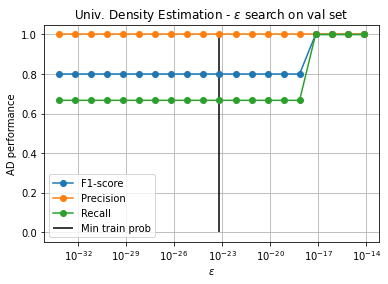

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

print('Univariate Density Estimation')
print('=============================')

# estimamos los parámetros de las distribuciones univariadas de cada feature
mus, sigmas = estimate_univariate_gaussian_parameters(dataset['X_train'])
# obtenemos las predicciones de valores de probabilidad sobre esos mismos datos
probs_train = univariate_gaussian(dataset['X_train'], mus, sigmas)
# buscamos los valores mínimos y máximos de probabilidades
min_train_prob = np.min(probs_train)
max_train_prob = np.max(probs_train)
print('')
print('Max prob. value in training set: {}'.format(max_train_prob))
print('Min prob. value in training set: {}'.format(min_train_prob))
print('')

# los rangos de búsqueda para los epsilons irán desde un valor muy chico hacia
# uno más grande
epsilons = min_train_prob * (10.0**np.arange(-10, 10, 1))
# inicializamos las listas de valores de F1-score, precision y recall
f1_scores = []
precisions = []
recalls = []

# predecimos las probabilidades sobre los datos de validación
probs_val = univariate_gaussian(dataset['X_val'], mus, sigmas)

# para cada valor de epsilon
for eps in epsilons:

  # obtenemos las muestars menores al valor epsilon dado
  predictions = probs_val < eps
  # calculamos las métricas
  f1_scores.append(f1_score(dataset['y_val'], predictions))
  precisions.append(precision_score(dataset['y_val'], predictions))
  recalls.append(recall_score(dataset['y_val'], predictions))
  # imprimimos por pantalla los resultados
  print('Epsilon: {}'.format(eps))
  print('-----------')
  print('F1-score: {:.4f}'.format(f1_scores[-1]))
  print('Precision: {:.4f}'.format(precisions[-1]))
  print('Recall: {:.4f}'.format(recalls[-1]))
  print('-----------')

# generamos un gráfico mostrando la evolución de todos los valores a la vez
plt.semilogx(epsilons, np.array(f1_scores), 'o-')
plt.semilogx(epsilons, np.array(precisions), 'o-')
plt.semilogx(epsilons, np.array(recalls), 'o-')
plt.vlines(min_train_prob, 0, 1)
plt.legend(['F1-score', 'Precision', 'Recall', 'Min train prob'])
plt.xlabel('$\epsilon$')
plt.ylabel('AD performance')
plt.grid(True)
plt.title('Univ. Density Estimation - $\epsilon$ search on val set')
plt.show()

Vemos que en todos los casos los valores de $\epsilon$ me aseguran un recall modesto (se me está escapando 1 de las 3 muestras anómalas), pero que no cometo ningún falso positivo. Necesito exceder el valor mínimo que tenía en mis datos de entrenamiento para encontrar algunas anomalías que me faltan y lograr subir el F1-score. Sin embargo, esto es un bardo, porque si recibimos muestras parecidas a las de entrenamiento (que sabemos que no son anómalas), las clasificaríamos como anómalas, y eso está mal!

#### 2.3. Multivariate Gaussian Density Estimation

El modelo univariado que estuvimos usando hasta ahora no tiene en cuenta las correlaciones entre las diferentes features. En consecuencia, analiza las características de manera independiente, ignorando si las relaciones entre unas y otras se vinculan con la "normalidad" de los datos.

El modelo multivariado incorpora una matriz de covarianza $\Sigma$ que reemplaza a los desvíos estándar $\sigma_i$ en la definición de la PDF y que cuantifica la interrelación entre las características. Incorporando un modelo multivariado podemos hacer un mejor uso del espacio de características, y en algunos problemas esto puede ser muy beneficioso.

Veamos entonces qué necesitamos cambiar respecto al ejemplo anterior apra poder utilizar este enfoque sobre los datos que tenemos. Primero necesitamos redefinir el proceso de estimación de parámetros (ya que ahora necesitamos estimar la matriz de covarianza en lugar de los desvíos). Luego, el proceso de estimación de las probabilidades también variará, ya que ahora alimentaremos directamente a la PDF con vectores de características, y no con cada una individualmente.

In [ ]:
def estimate_multivariate_gaussian_parameters(dataset):
  '''
  Estimamos los valores de medias y matriz de covarianza de nuestro dataset
  '''
  # estimamos la media
  mu = np.mean(dataset, axis=0)
  # estimamos la matriz de covarianza
  sigma = np.cov(dataset.T)

  print(sigma)
  
  return mu, sigma


def multivariate_gaussian(dataset, mu, cov_matrix):
  '''
  Obtenemos los valores de probabilidad asociados a cada muestra, en este caso
  según los valores de media dados y una matriz de covarianza
  '''

  # obtenemos la distribución de probabilidades
  pdf = multivariate_normal(mean=mu, cov=cov_matrix)
  # la aplicamos sobre los datos
  probs = pdf.pdf(dataset)
  
  return probs

El proceso de estimación de $\epsilon$ es equivalente al que veníamos utilizando anteriormente:

Multivariate Density Estimation
[[ 1.01       -0.08003739 -0.04143057  0.06337493  0.18851217  0.15920223
   0.01367489  0.16811044  0.1339608   0.12444154  0.06903432  0.08688713
   0.04407203 -0.25985634  0.07192861  0.24361452 -0.01347476  0.07006299]
 [-0.08003739  1.01        0.40189033  0.16954376  0.36627909  0.33793078
   0.0027884  -0.00700758 -0.17366107 -0.0465972   0.27881229  0.06391474
   0.09407806 -0.10559383 -0.01008116 -0.08710646  0.00341922 -0.10831427]
 [-0.04143057  0.40189033  1.01        0.42608439  0.573598    0.3886538
   0.24292956 -0.01761092 -0.06910169  0.04017681 -0.03854769  0.09870507
   0.12950705  0.01106701 -0.0253352   0.11108829  0.13257649  0.1611788 ]
 [ 0.06337493  0.16954376  0.42608439  1.01        0.33954667  0.20714077
   0.18957013 -0.00117633 -0.02915163  0.10984146  0.09288868  0.12653733
   0.18243784  0.14283749  0.09801095  0.13967412  0.1082339   0.34367019]
 [ 0.18851217  0.36627909  0.573598    0.33954667  1.01        0.48057129
   

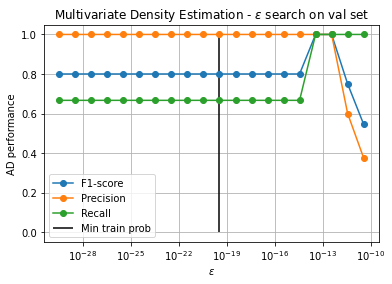

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

print('Multivariate Density Estimation')
print('=============================')

# estimamos los parámetros de las distribuciones univariadas de cada feature
mus, sigmas = estimate_multivariate_gaussian_parameters(dataset['X_train'])
print(sigmas.shape)
#print(sigmas)
# obtenemos las predicciones de valores de probabilidad sobre esos mismos datos
probs_train = multivariate_gaussian(dataset['X_train'], mus, sigmas)
# buscamos los valores mínimos y máximos de probabilidades
min_train_prob = np.min(probs_train)
max_train_prob = np.max(probs_train)
print('')
print('Max prob. value in training set: {}'.format(max_train_prob))
print('Min prob. value in training set: {}'.format(min_train_prob))
print('')

# los rangos de búsqueda para los epsilons irán desde un valor muy chico hacia
# uno más grande
epsilons = min_train_prob * (10.0**np.arange(-10, 10, 1))
# inicializamos las listas de valores de F1-score, precision y recall
f1_scores = []
precisions = []
recalls = []

# predecimos las probabilidades sobre los datos de validación
probs_val = multivariate_gaussian(dataset['X_val'], mus, sigmas)

# para cada valor de epsilon
for eps in epsilons:

  # obtenemos las muestars menores al valor epsilon dado
  predictions = probs_val < eps
  # calculamos las métricas
  f1_scores.append(f1_score(dataset['y_val'], predictions))
  precisions.append(precision_score(dataset['y_val'], predictions))
  recalls.append(recall_score(dataset['y_val'], predictions))
  # imprimimos por pantalla los resultados
  print('Epsilon: {}'.format(eps))
  print('-----------')
  print('F1-score: {:.4f}'.format(f1_scores[-1]))
  print('Precision: {:.4f}'.format(precisions[-1]))
  print('Recall: {:.4f}'.format(recalls[-1]))
  print('-----------')

# generamos un gráfico mostrando la evolución de todos los valores a la vez
plt.semilogx(epsilons, np.array(f1_scores), 'o-')
plt.semilogx(epsilons, np.array(precisions), 'o-')
plt.semilogx(epsilons, np.array(recalls), 'o-')
plt.vlines(min_train_prob, 0, 1)
plt.legend(['F1-score', 'Precision', 'Recall', 'Min train prob'])
plt.xlabel('$\epsilon$')
plt.ylabel('AD performance')
plt.grid(True)
plt.title('Multivariate Density Estimation - $\epsilon$ search on val set')
plt.show()

Acá vemos que sigue ocurriendo lo mismo que veíamos antes: se nos está escapando una muestra cuando usamos valores de $\epsilon$ muy bajos, y eso nos está tirando el recall hacia abajo (y por ende, el F1-score). Cuando empezamos a considerar valores más alto que el mínimo de los de entrenamiento, vemos que el algoritmo mantiene una performance similar hasta que para $10^{-13}$ encuentra la muestra que le faltaba. Sin embargo, si aumentamos un poco más el $\epsilon$ vemos que ahora empieza a tener falsos positivos, y eso genera una caída en la precision y también en el F1-score.

#### 2.4. Local Outlier Factor

El método de [Local Outlier Factor (LOF)](https://en.wikipedia.org/wiki/Local_outlier_factor) se basa en analizar las densidades de muestras en el espacio de características, estudiando para ello las distancias entre los $k$ vecinos más cercanos de cada una. 

La principal ventaja de este algoritmo es que no necesitamos datos anotados para entrenarlo. Simplemente lo alimentamos con un gran número de muestras, y el algoritmo etiquetará como anómalas aquellas cuyo LOF sea mayor a 1.

En Sklearn, LOF viene implementado dentro del paquete ```neighbors```. Su  hiperparámetro más importante es ```n_neighbors``` ($k$, número de vecinos más cercanos que se estudiarán para el cálculo del LOF), aunque también podríamos cambiar la métrica de distancia, de la misma forma que podíamos hacerlo en $k$-NN. También tenemos que indicarle que lo queremos utilizar para detección de anomalías, pasándole ```novelty=True```. Si no lo hiciéramos, en lugar de utilizar ```fit``` sobre datos de entrenamiento primero y luego ```predict``` sobre nuevos datos deberíamos juntar todos los datos en un único conjunto, y utilizar el método ```fit_predict```. Esta última versión se utiliza para descubrir anomalías en bases de datos en las que las anomalías no están definidas per se.

Eventualmente podríamos alimentar el algoritmo con (algunas) muestras anómalas durante el entrenamiento. Si lo hacemos, deberíamos decírselo utilizando el parámetro ```contamination```, que corresponde a un float que indica la proporción de muestras anómalas en los datos.

La función ```predict``` nos va a dar valores 1 y -1, donde 1 corresponde a inliers y -1 a outliers. Analicemos la performance del algoritmo para diferentes valores de $k$.

Local Outlier Factor
K: 5
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
K: 10
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
K: 15
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
K: 20
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
K: 25
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------
K: 30
-----------
F1-score: 0.8000
Precision: 1.0000
Recall: 0.6667
-----------


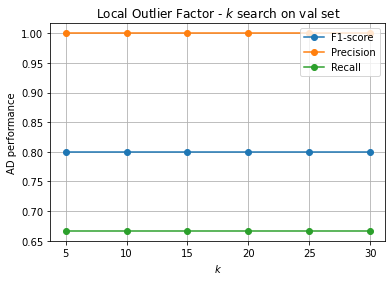

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

print('Local Outlier Factor')
print('=============================')

# inicializamos las listas para valores de F1-score, precision y recall
f1_scores = []
precisions = []
recalls = []

# inicializamos la lista de valores de K que analizaremos
k_values = [5, 10, 15, 20, 25, 30]

# iteramos por cada valor de k
for k in k_values:

  # inicializamos el modelo
  lof = LocalOutlierFactor(n_neighbors=k, novelty=True)
  # lo alimentamos con los datos de entrenamiento
  lof.fit(dataset['X_train'])
  # y ahora lo probamos sobre las muestras de validación
  y_hat_val = lof.predict(dataset['X_val'])
  # identificamos las potenciales anomalías
  predictions = y_hat_val < 0

  # calculamos las métricas
  f1_scores.append(f1_score(dataset['y_val'], predictions))
  precisions.append(precision_score(dataset['y_val'], predictions))
  recalls.append(recall_score(dataset['y_val'], predictions))
  # imprimimos por pantalla los resultados
  print('K: {}'.format(k))
  print('-----------')
  print('F1-score: {:.4f}'.format(f1_scores[-1]))
  print('Precision: {:.4f}'.format(precisions[-1]))
  print('Recall: {:.4f}'.format(recalls[-1]))
  print('-----------')

# generamos un gráfico mostrando la evolución de todos los valores a la vez
plt.plot(k_values, np.array(f1_scores), 'o-')
plt.plot(k_values, np.array(precisions), 'o-')
plt.plot(k_values, np.array(recalls), 'o-')
plt.legend(['F1-score', 'Precision', 'Recall'])
plt.xlabel('$k$')
plt.ylabel('AD performance')
plt.grid(True)
plt.title('Local Outlier Factor - $k$ search on val set')
plt.show()


En este caso vemos que los cambios en $k$ no afectan la performance global del algoritmo. En particular, LOF no está pudiendo detectar algunos de los outliers en el conjunto (por lo que el recall se mantiene constante abajo). Esto puede llegar a deberse a que estamos usando clases que fueron asignadas en función a una regla rígida sobre el LOF (las que vimos durante la clase). A veces ocurre que algunas muestras (las ubicadas en los bordes) pueden llegar a ser outliers (o no), y "la regla rígida" no las tiene en cuenta.

Podemos predecir el LOF de cada muestra, y utilizarlos para generar curvas de precision/recall, estimar el área bajo cada curva y encontrar el mejor valor de $k$ en base a eso. Los podemos obtener utilizando el método ```score_samples```, que nos devuelve los valores de LOF con un signo menos delante.

In [ ]:
# obtenemos los scores sobre los datos de validación
y_hat_val = lof.score_samples(dataset['X_val'])

# los imprimimos y comparamos con las etiquetas
print(y_hat_val)
print(dataset['y_val'])

[-0.98164013 -1.01464335 -1.06553728 -0.98073686 -0.99740074 -1.0382831
 -1.00590156 -1.06580685 -1.02005213 -1.03339221 -1.03234969 -1.0308308
 -1.32154954 -3.06649863 -2.97586268]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


Si recordamos de la teoría, los LOF mayores a 1 implicaban una mayor chance de estar frente a un outlier. En este caso, al estar invertidos, los scores nos quedarían al revés, y no nos servirían para evaluar correctamente el algoritmo utilizando curvas de precision/recall. Por consiguiente, debemos invertirlos (quitarles el signo), y usarlos para repetir la búsqueda de valores óptimos de K:


Local Outlier Factor
K: 5
-----------
AUC: 1.0000
-----------

K: 10
-----------
AUC: 1.0000
-----------

K: 15
-----------
AUC: 1.0000
-----------

K: 20
-----------
AUC: 1.0000
-----------

K: 25
-----------
AUC: 1.0000
-----------

K: 30
-----------
AUC: 1.0000
-----------



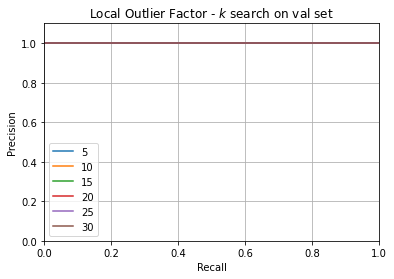

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.neighbors import LocalOutlierFactor

print('Local Outlier Factor')
print('=============================')

# inicializamos las listas para valores de auc
auc_values = []

# inicializamos la lista de valores de K que analizaremos
k_values = [5, 10, 15, 20, 25, 30]

# iteramos por cada valor de k
for k in k_values:

  # inicializamos el modelo
  lof = LocalOutlierFactor(n_neighbors=k, novelty=True)
  # lo alimentamos con los datos de entrenamiento
  lof.fit(dataset['X_train'])
  # y ahora lo probamos sobre las muestras de validación, pero esta vez 
  # recuperamos los LOF
  y_hat = lof.predict(dataset['X_val'])
  #print(y_hat)
  y_hat_val = -lof.score_samples(dataset['X_val'])
  #print(y_hat_val)

  # generamos la curva de precision/recall y calculamos el AUC
  pr, re, thresh = precision_recall_curve(dataset['y_val'], y_hat_val)
  auc_pr_re = auc(re, pr)
  #print(thresh)
  auc_values.append(auc_pr_re)
  
  # imprimimos la curva
  plt.plot(re, pr)

  # imprimimos por pantalla los resultados
  print('K: {}'.format(k))
  print('-----------')
  print('AUC: {:.4f}'.format(auc_pr_re))
  print('-----------')
  print('')

# generamos un gráfico mostrando la evolución de todos los valores a la vez
plt.legend(k_values)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.grid(True)
plt.title('Local Outlier Factor - $k$ search on val set')
plt.show()


Utilizando los scores vemos que es posible hallar umbrales que nos aseguran una performance perfecta. Esto indica que eventualmente el criterio rígido que utilizamos originalmente para decidir qué era un inlier y qué era un outlier tal vez quede corto.

#### 2.5. One Class SVM (o Support Vector Data Description)

Originalmente, la One Class SVM fue la primera extensión al método de Support Vector Machines para trabajar en problemas de detección de anomalías. En lugar de predecir un hiperplano que separe dos nubes de puntos, el modelo intenta correr las muestras de entrenamiento y colocarlas lejos del origen de coordenadas, en donde ubica un hiperplano según el cual todo lo que ocurra debajo de él será una anomalía.

El modelo de Support Vector Data Description (o SVDD) es un poco más rico, porque en lugar de un hiperplano intenta encontrar la mejor esfera que contenga a los datos de entrenamiento (que son todos no anómalos). Luego, dada una muestra nueva, la clasificará como anómala si no cae dentro de la hiperesfera aprendida.

Un dato curioso es que SVDD permite incorporar kernels, igual que la SVM clásica. Y para la mayoría de esos kernels, SVDD no es más que otra forma de describir la One Class SVM. Por eso es que en general van a ver que mucha gente se refiere a SVDD como One Class SVM, cuando técnicamente son distintos.

Vamos a aplicar nuestra One Class SVM sobre los datos que estamos utilizando, utilizando la clase ```OneClassSVM``` del paquete ```svm``` de Sklearn. 

Necesitamos elegir varios hiperparámetros.
* Del que jamás vamos a zafar es $\nu$ (```nu```), que toma valores entre (0, 1] y nos permite controlar qué tan tolerante queremos que sea el decision boundary. Si queremos que el modelo acepte más errores, usamos un $\nu$ más cercano a 1. Si queremos que sea más rígido, lo bajamos más cerca de 0.
* Si elegimos un kernel (```kernel```) entonces debemos setearle sus parámetros, igual que como hacíamos con la SVM.

En el siguiente ejemplo vamos a buscar la mejor combinación de parámetros $\nu$ y $\gamma$ de la RBF, usando los datos de validación.


One Class SVM
Best F1-score: 1.0


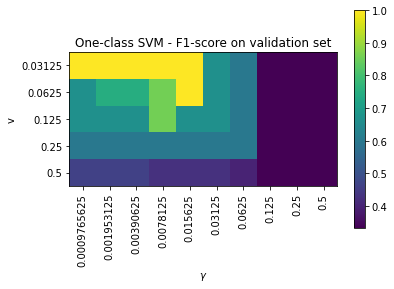

In [ ]:
from sklearn.svm import OneClassSVM

# establecemos los valores de nu y gamma que vamos a probar
nu_vals = [0.03125, 0.0625, 0.125, 0.25, 0.5]
gamma_vals = list(np.arange(-10, 0))

# inicializamos una matriz donde vamos a ir guardando los valores de F1-score
f1_scores = np.zeros((len(nu_vals), len(gamma_vals)))

# probamos todas las configuraciones
i = 0
for nu in nu_vals:
  j = 0
  for gamma in gamma_vals:
    # creamos un objeto de la clase OneClassSVM con la configuración elegida
    model = OneClassSVM(kernel='rbf', gamma=2.0**gamma, nu=nu)
    # lo entrenamos sobre nuestros datos de entrenamiento
    model.fit(dataset['X_train'])
    # lo evaluamos sobre nuestros datos de validación
    y_hat_val = model.predict(dataset['X_val']) < 0
    # calculamos el F1-score
    f1_scores[i,j] = f1_score(dataset['y_val'], y_hat_val)
    j=j+1
  i=i+1

# imprimimos el mejor valor de F1-score
print('One Class SVM')
print('Best F1-score: {}'.format(np.max(f1_scores)))

# mostramos un gráfico
fig, ax = plt.subplots()
pos = ax.imshow(f1_scores)
ax.set_title('One-class SVM - F1-score on validation set')
ax.set_xlabel('$\gamma$')
ax.set_xticks(np.arange(len(gamma_vals)))
ax.set_xticklabels(2.0**np.array(gamma_vals),rotation=90)
ax.set_yticks(np.arange(len(nu_vals)))
ax.set_yticklabels(nu_vals)
ax.set_ylabel('v')
fig.colorbar(pos, ax=ax)
plt.show()

Vemos que nuestra One Class SVM con kernel RBF obtiene un F1-score perfecto para $\nu = 0.0625$ y $\gamma=2^{-6}$. Como siempre, recordemos hacer esta búsqueda cuando apliquemos nuestros algoritmos.

#### 2.6 Isolation Forests

El último de los modelos para detección de anomalías con el que vamos a trabajar es el de Isolation Forests. Este algoritmo se basa en una serie de árboles (Isolation Trees, o iTrees) que se construyen aleatoriamente como los que veníamos viendo en Random Forest. Sin embargo, en lugar de buscar combinaciones óptimas para dividir los datos entre una clase y otra, el proceso de construcción de los árboles se centra en probar aleatoriamente diferentes valores de umbral para features sorteadas aleatoriamente, buscando lograr aislar a cada muestra de entrenamiento. El score que determina qué tan probable es que una muestra sea anómala estará dado por la cantidad de niveles que fueron necesarios para lograr aislarlo. Se supone que si contamos con anomalías (ya sea en nuestros datos de entrenamiento o en los datos que vayan a venir después), esos puntos serán más fáciles de aislar, al estar más separados de la distribución general de muestras no anómalas.

Como todos los algoritmos basados en árboles, el Isolation Forest viene implementado bajo ese nombre (```IsolationForest```) en el paquete ```ensemble``` de Sklearn. El hiperparámetro clave aquí es ```n_estimators```, como siempre, que determina el número de árboles que queremos utilizar.

Probemos el algoritmo sobre los datos que estamos utilizando:

Isolation Forest
Best F1-score: 0.5454545454545454


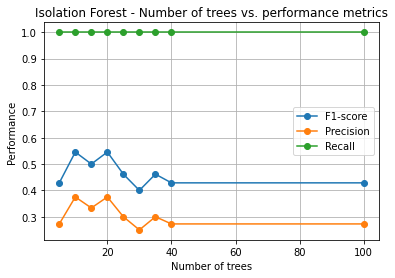

In [ ]:
from sklearn.ensemble import IsolationForest

# establecemos los valores de cantidad de árboles que queremos probar
T_values = [5, 10, 15, 20, 25, 30, 35, 40, 100]

# inicializamos una matriz donde vamos a ir guardando los valores de F1-score
f1_scores = []
precisions = []
recalls = []

# probamos todas las configuraciones
for T in T_values:
  # creamos un objeto de la clase IsolationForest con la configuración elegida
  model = IsolationForest(n_estimators=T)
  # lo entrenamos sobre nuestros datos de entrenamiento
  model.fit(dataset['X_train'])
  # lo evaluamos sobre nuestros datos de validación
  y_hat_val = model.predict(dataset['X_val']) < 0
  # calculamos el F1-score
  f1_scores.append(f1_score(dataset['y_val'], y_hat_val))
  precisions.append(precision_score(dataset['y_val'], y_hat_val))
  recalls.append(recall_score(dataset['y_val'], y_hat_val))

# imprimimos el mejor valor de F1-score
print('Isolation Forest')
print('Best F1-score: {}'.format(np.max(f1_scores)))

# mostramos un gráfico
plt.plot(T_values, f1_scores, '-o')
plt.plot(T_values, precisions, '-o')
plt.plot(T_values, recalls, '-o')
plt.title('Isolation Forest - Number of trees vs. performance metrics')
plt.xlabel('Number of trees')
plt.ylabel('Performance')
plt.legend(['F1-score', 'Precision', 'Recall'])
plt.grid(True)
plt.show()

Recordemos que el Isolation Forest es un método por ensemble cuyos árboles se generan de forma aleatoria. Esto implica que si ejecutamos varias veces el código anterior, obtendremos diferentes resultados, a menos que seteemos una semilla aleatoria.

En general, en las corridas que hicimos vimos que los errores se deben a un número alto de falsos positivos, que tironea hacia abajo el F1-score producto de una caída en la precision. Si nuestra aplicación requiere que no se nos escape ni un solo posible outlier, tal vez esta solución sea correcta.

¿Podrá tener que ver con que estamos desaprovechando el score? Veamos qué pasa si evaluamos en términos del AUC bajo la curva de precision/recall:

Isolation Forest
Best AUC value: 1.0


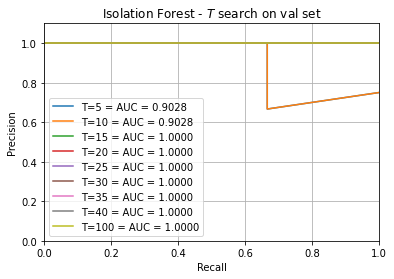

In [ ]:
from sklearn.ensemble import IsolationForest

# establecemos los valores de cantidad de árboles que queremos probar
T_values = [5, 10, 15, 20, 25, 30, 35, 40, 100]
T_values_labels = []

# inicializamos una matriz donde vamos a ir guardando los valores de F1-score
auc_values = []

# probamos todas las configuraciones
for T in T_values:
  # creamos un objeto de la clase IsolationForest con la configuración elegida
  model = IsolationForest(n_estimators=T)
  # lo entrenamos sobre nuestros datos de entrenamiento
  model.fit(dataset['X_train'])
  # lo evaluamos sobre nuestros datos de validación
  y_hat_val = - model.score_samples(dataset['X_val'])
  #print(y_hat_val)
  # calculamos el F1-score
  pr, re, _ = precision_recall_curve(dataset['y_val'], y_hat_val)
  auc_values.append(auc(re, pr))
  plt.plot(re, pr)
  T_values_labels.append('T={} = AUC = {:.4f}'.format(T, auc_values[-1]))

# imprimimos el mejor valor de F1-score
print('Isolation Forest')
print('Best AUC value: {}'.format(np.max(auc_values)))

# generamos un gráfico mostrando la evolución de todos los valores a la vez
plt.legend(T_values_labels)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.grid(True)
plt.title('Isolation Forest - $T$ search on val set')
plt.show()


Al menos en los experimentos que hemos corrido nosotros, hemos visto que en la gran mayoría de los casos podemos obtener un area bajo la curva de precision/recall de 1. Esto implica que utilizando los valores de score generados por el Isolation Forest podríamos resolver el problema que tenemos con los falsos positivos.

### 3. Clustering

Los algoritmos de clustering nos permiten hacer análisis no supervisado de los datos a través de una serie de estrategias que asignan a cada muestra a un agrupamiento o cluster. A menudo encontrarán en los libros que se habla de "análisis de cluster". Esto se debe a que estos agrupamientos no tienen semántica a priori, pero nos sirven para estudiar qué similitudes existen entre las muestras, para posteriormente sacar conclusiones más ricas que nos ayuden en la toma de decisiones.

Clustering está en el centro del famoso Big Data que oímos nombrar en todas partes. Usando estas técnicas podemos hallar relaciones entre los datos que quizá desconocíamos, y utilizar esas nuevas conclusiones como guía para tal o cual aplicación.

#### 3.1. Preparamos los datos

En esta unidad vamos a ver algunas de las estrategias de clustering más populares, utilizando datos de la Organización Mundial de la Salud (WHO) sobre expectativa de vida en numerosos países. La info sobre los datos está disponible en [este sitio](https://www.kaggle.com/kumarajarshi/life-expectancy-who).

Lo primero que haremos será descargarlos e imprimir algunas muestras:

In [ ]:
import wget

# inicializamos un diccionario donde guardaremos el dataset
dataset = dict()
dataset['url'] = 'https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/LifeExpectancyWHO/Life Expectancy Data.csv'
dataset['extension'] = '.csv'
dataset['filename'] = path.join(datasets_folder, 'life_expectancy' + dataset['extension']) 
if not path.exists(dataset['filename']):  # descargar solamente si no existe
  wget.download(dataset['url'], dataset['filename'])
else:
  print('El archivo {} ya existe.'.format(dataset['filename']))

# accedemos a los datos usando Pandas
original_table = pd.read_table(dataset['filename'],sep=',')
print(original_table)


          Country  Year  ... Income composition of resources  Schooling
0     Afghanistan  2015  ...                           0.479       10.1
1     Afghanistan  2014  ...                           0.476       10.0
2     Afghanistan  2013  ...                           0.470        9.9
3     Afghanistan  2012  ...                           0.463        9.8
4     Afghanistan  2011  ...                           0.454        9.5
...           ...   ...  ...                             ...        ...
2933     Zimbabwe  2004  ...                           0.407        9.2
2934     Zimbabwe  2003  ...                           0.418        9.5
2935     Zimbabwe  2002  ...                           0.427       10.0
2936     Zimbabwe  2001  ...                           0.427        9.8
2937     Zimbabwe  2000  ...                           0.434        9.8

[2938 rows x 22 columns]


El archivo contiene una serie de estadísticas sobre muchos países, categorizadas por año de extracción. Veamos de qué se trata:

In [ ]:

# armamos una lista con los nombres de las features
feature_names = []
for col in original_table.columns: 
    feature_names.append(col)

# identificamos los países que tienen entradas en la tabla
countries = np.unique(original_table['Country'].to_numpy())

print('Features: {}'.format(feature_names))
print('Countries: {}'.format(countries))

Features: ['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
Countries: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Côte d'Ivoire" "Democratic People's Republic of Korea"
 'Democratic Republic o

Las features incluyen:
* El estado del país (si es desarrollado o no desarrollado).
* La expectativa de vida (en años).
* La mortalidad adulta.
* La cantidad de muertes de niñxs por cada 1000 habitantes.
* La cantidad de alcohol consumido por mayores de 15 años per cápita (en litros de alcohol puro).
* El porcentaje del PBI per cápita invertido en salud.
* El porcentaje de vacunación contra la hepatitis B en niñxs de 1 año.
* El número de casos de sarampión reportado por cada 1000 habitantes.
* Índice de masa corporal promedio de la población
* Número de muertes por debajo de los 5 años cada 1000 habitantes.
* El porcentaje de vacunación contra la polio en niñxs de 1 año.
* El porcentaje de inversión en salud del Estado en función del presupuesto total del país.
* El porcentaje de vacunación contra la difteria en niñxs de 1 año.
* La cantidad de muertes por VIH/SIDA cada 1000 habitantes en niñxs de 0 a 4 años.
* El producto bruto interno per cápita.
* La cantidad de habitantes del país.
* Prevalencia de flacura entre niñxs y adolescentes de 10 a 19 años.
* Prevalencia de flacura entre niñxs de 5 a 9 años.
* Índice de desarrollo humano (en término de la composición del ingreso).
* Número de años de escolarización.

Como verán, un montón de información técnica sobre los diferentes países.
Las estadísticas vienen por año, así que lo que haremos será quedarnos con un año particular (el 2015, que es el último registrado). Además, necesitamos convertir el único dato categórico a números. No usaremos one-hot encoding porque en este bello mundo desigual, un país desarrollado es más que uno en desarrollo. Finalmente, eliminaremos las columnas "País" y "Año" de las matrices, porque no nos interesan.

In [ ]:
# crearemos una matriz con los datos convertidos a Numpy
data_as_numpy = None
# iteramos por cada uno de los países
for country in countries:
  # nos quedamos con todas las filas correspondientes al país
  this_country_rows = original_table.loc[original_table['Country']==country]
  # y de ahí extraemos solamente la fila correspondiente al año 2015
  last_year_row = this_country_rows[this_country_rows['Year']==2015]
  # la pasamos a numpy
  last_year_row = last_year_row.to_numpy()
  # convertimos el atributo categórico "Developed / Developing" a un número
  if last_year_row[:,2]=='Developed':
    last_year_row[:,2] = 1
  else:
    last_year_row[:,2] = 0
  # concatenamos la entrada a la matriz que vamos llevando
  if data_as_numpy is None:
    data_as_numpy = last_year_row
  else:
    data_as_numpy = np.concatenate((data_as_numpy, last_year_row), axis=0)

# recuperamos los nombres de los países
countries = data_as_numpy[:,0]
# reacomodamos los nombres de las features (sacando el nombre de país y el año)
feature_names = feature_names[2:]
# creamos una matriz de diseño inicial
X = np.asarray(data_as_numpy[:,2:], dtype=float)
print(X.shape)

(183, 20)


El dataset también reporta algunos datos faltantes (que aparecen como NaNs), así que lo que haremos será remover las features para las que no tengamos datos para todos los países.

In [ ]:
# crearemos una nueva matriz de diseño, pero sin las columnas que tengan NaNs
new_X = None
new_feature_names = []
# por cada una de mis columnas
for i in range(X.shape[1]):
  # obtengo si hay NaNs o no en alguna celda
  there_are_nans = np.unique(np.isnan(X[:,i]))
  # si no tiene ningún NaN
  if not ((len(there_are_nans)==2) or ((len(there_are_nans)==1 and (there_are_nans[0])))):
    # agrego la entrada a la nueva matriz
    if new_X is None:
      new_X = np.expand_dims(X[:,i],axis=1)
    else:
      new_X = np.concatenate((new_X, np.expand_dims(X[:,i],axis=1)), axis=1)
    new_feature_names.append(feature_names[i])

print('Num of countries: {}'.format(len(countries)))
print('Num of features: {}'.format(len(new_feature_names)))
print('Dataset size: {}'.format(new_X.shape))
print(new_feature_names)

# reemplazo la matriz de diseño anterior
X = new_X


Num of countries: 183
Num of features: 10
Dataset size: (183, 10)
['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Measles ', 'under-five deaths ', 'Total expenditure', 'Diphtheria ', 'GDP', 'Population']


Nos queda finalmente normalizar los datos y dejar bien armados los campos del dataset. Recuerden que como estamos trabajando con un problema no supervisado en el que simplemente queremos estudiar los datos, no necesitamos partirlos en training / validation / test.

In [ ]:
# asignamos los nombres de los países y las features
dataset['countries'] = countries
dataset['feature_names'] = new_feature_names

# calculamos mínimos y máximos y normalizamos con eso
dataset['min'] = np.min(X, axis=0)
dataset['max'] = np.max(X, axis=0)

dataset['X'] = (X - dataset['min']) / (dataset['max'] - dataset['min'])

Ya con estos datos bien listos, planteemos la siguiente pregunta: ¿qué similitudes existen entre los países en términos de sus indicadores sanitarios?

#### 3.2. K-Means

El algoritmo de K-means es el más comunmente utilizado en problemas de clustering. Se basa en descubrir K centroides en los datos que me representen los diferentes agrupamientos que puedan llegar a existir, de manera iterativa y basándose en la distancia entre las muestras. Inicialmente se eligen al azar K muestras que operarán como centroides, y luego se realiza un proceso iterativo que consiste en dos fases:

1. Fase de asignación: cada muestra es asignada al cluster correspondiente al centroide más cercano.
2. Fase de actualización: se actualiza el centroide tomando la media de las muestras dentro del cluster.

Este proceso se repite hasta estabilizar lo que se conoce como **suma de distancias cuadradas**, que no es más que la suma de las distancias al cuadrado de cada muestra al centroide asociado a su cluster. Se espera que cuando esto deje de variar, estemos ante una posible solución.

En Sklearn, el algoritmo de K-means se llama ```KMeans``` y viene dentro del paquete ```cluster```. El hiperparámetro más importante es ```n_clusters```, que no es más que el valor de K. Vamos a generar una primera partición en 4 clusters y ver los resultados que obtenemos.

In [ ]:
from sklearn.cluster import KMeans

# inicializamos un objeto de la clase KMeans con el modelo
kmeans = KMeans(n_clusters=4, verbose=0, random_state=10)
# lo aplicamos sobre nuestros datos para hallar los centroides
kmeans.fit(dataset['X'])
# y obtenemos los clusters a los que fueron asignadas las muestras
clusters_kmeans = kmeans.predict(dataset['X'])

# imprimimos por pantalla los nombres de los países asignados a cada cluster
for k in np.unique(clusters_kmeans):
  print('Cluster {}'.format(k))
  print(countries[clusters_kmeans==k])
  print('======')

Cluster 0
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belize' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Brazil' 'Brunei Darussalam' 'Burkina Faso'
 'Cabo Verde' 'Cambodia' 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica'
 'Cuba' "Democratic People's Republic of Korea" 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Fiji' 'Finland' 'France'
 'Georgia' 'Greece' 'Grenada' 'Honduras' 'Iran (Islamic Republic of)'
 'Israel' 'Jamaica' 'Jordan' 'Kazakhstan' 'Kuwait' 'Kyrgyzstan' 'Lebanon'
 'Libya' 'Madagascar' 'Malaysia' 'Maldives' 'Mauritania' 'Mauritius'
 'Mexico' 'Micronesia (Federated States of)' 'Mongolia' 'Montenegro'
 'Morocco' 'Nicaragua' 'Niger' 'Oman' 'Panama' 'Paraguay' 'Qatar'
 'Republic of Korea' 'Republic of Moldova' 'Russian Federation'
 'Saint Lucia' 'Saint Vincent and the Grenadines' 'Samoa'
 'Sao Tome and Principe' 'Saudi Arabia' 'Serbia' 'S

Este primer agrupamiento nos permite ver algunas cosas interesantes. Por ejemplo, en el cluster 3 vemos que se agruparon la gran mayoría de los países africanos. En el cluster 2, otros países de África y algunos de Asia, Europa del Este y el norte de Sudamérica y el Caribe. En el cluster 0 (el más grande) vemos países de un montón de regiones del mundo. Finalmente, en el cluster 1 vemos un gran número de países europeos junto a USA, Australia, entre otros.
**¿Qué nos estará planteando esta partición?**

El principal problema de K-means es cómo elegir el valor de K. La herramienta más utilizada es el llamado "Elbow plot" (o "gráfico del codo") que nos permite estudiar la evolución de la suma de distancias al cuadrado en función de K. A esas distancias también la van a oir nombrar como "WCSS": "Within Cluster Sum of Squares". Es de esperar que este número se reduzca a medida que K aumente (en el caso donde K = número de muestras, la distancia al centroide de cada muestra sería 0, porque sería la muestra misma). El punto óptimo de K es "el codo" de la curva: es decir, el punto donde la suma de diferencias cuadradas deja de disminuir a un ritmo alto. Veamos qué obtenemos:

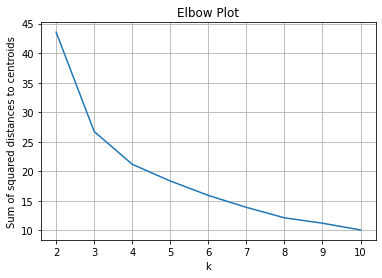

In [ ]:
def elbow_plot(X, n):
  '''
  Imprimo el Elbox plot para un dataset X dado y K={2, ..., n}
  '''
  # genero las particiones para diferentes valores de k, desde 1 a n
  kMeansVar = [KMeans(n_clusters=k).fit(X) for k in range(2, n+1)]
  # extraigo la suma de distancias entre cada muestra y los centroides
  sum_of_squared_distances = [km.inertia_ for km in kMeansVar]
  return sum_of_squared_distances

# recupero la suma de distancias cuadradas para valores de k de 2 a 10
N = 10
sum_of_squared_distances = elbow_plot(dataset['X'], N)

fig, ax = plt.subplots()
ax.plot(sum_of_squared_distances)
ax.grid(True)
ax.set_title('Elbow Plot')
ax.set_xlabel('k')
ax.set_xticklabels(np.arange(1,N+1))
ax.set_ylabel('Sum of squared distances to centroids')
plt.show()

En este gráfico vemos que quizá la elección de $K=4$ era la correcta. Eventualmente podríamos explorar algunos otros valores más altos y ver a qué conclusiones podemos arribar.

#### 3.3. Clustering Jerárquico

El algoritmo de clustering jerárquico construye los clusters iterativamente y de manera jerárquica, lo que nos permite evitar tener que elegir el número de clusters para construirlos. 

Existen dos formas de hacerlo: aglomerativa o divisiva. En el enforme aglomerativo tomamos diferentes pares de muestras y las unimos según qué tan cerca se encuentren entre sí, hasta unirlas a todas en un único clúster. Más en detalle:

1. Al principio, tratamos a cada punto como un cluster. O sea, tenemos K = N clusters.
2. Formamos un cluster uniendo a los dos puntos más cercanos. Esto nos reduce el número de cluster a K = N-1.
3. Formamos más clusters uniendo los dos clusters más cercanos entre sí. Podemos comparar muestras entre sí, o muestras con clusters o clusters. Cómo hacemos esa comparación depende del criterio de enlace que utilicemos.
4. Repetimos los pasos de 2 a 3 hasta que todo nos queda en un único cluster.

Iterativamente podemos ir construyendo una representación gráfica conocida como dendrograma, en donde unimos las muestras entre sí según vayamos poniéndolas en un mismo cluster, y donde representamos las uniones con una altura equivalente a la distancia euclidea entre los elementos que se unen.

En el siguiente ejemplo vamos a construir un dendograma usando ```scipy```, una librería que hasta ahora no habíamos utilizado. Necesitamos importar las funciones ```linkage``` (que realiza el clustering aglomerativo y nos deja los datos listos para construir el dendrograma) y ```dendrogram``` (que nos permite graficarlo).

```linkage``` nos pide un parámetro, ```method```, que corresponde al criterio de enlace, o la estrategia utilizada para calcular la distancia entre nuevos clusters. Siempre unimos clusters con distancia mínima entre sí, pero el valor que utilizamos para comparar puede cambiar. Si usamos ```single```, calculamos todas las distancias entre todos los puntos de los dos clusters que analizamos, nos quedamos con la mínima, y eso es lo que vamos comparando. Si usamos ```complete```, hacemos lo mismo pero con la máxima distancia entre muestras. Si usamos ```average```, el promedio. Si usamos ```weighted```, calculamos la distancia entre los dos subclusters que uní previamente y el nuevo cluster al que estoy considerando unirme, y tomo el promedio de esos dos. Si uso ```centroid```, comparo distancia entre centroides. Y así... Hay montones de variantes.

Usemos la más sencilla, comparar por distancia mínima a las muestras. Podríamos probar otras, si quisiéramos, modificando ```method``` en el código.

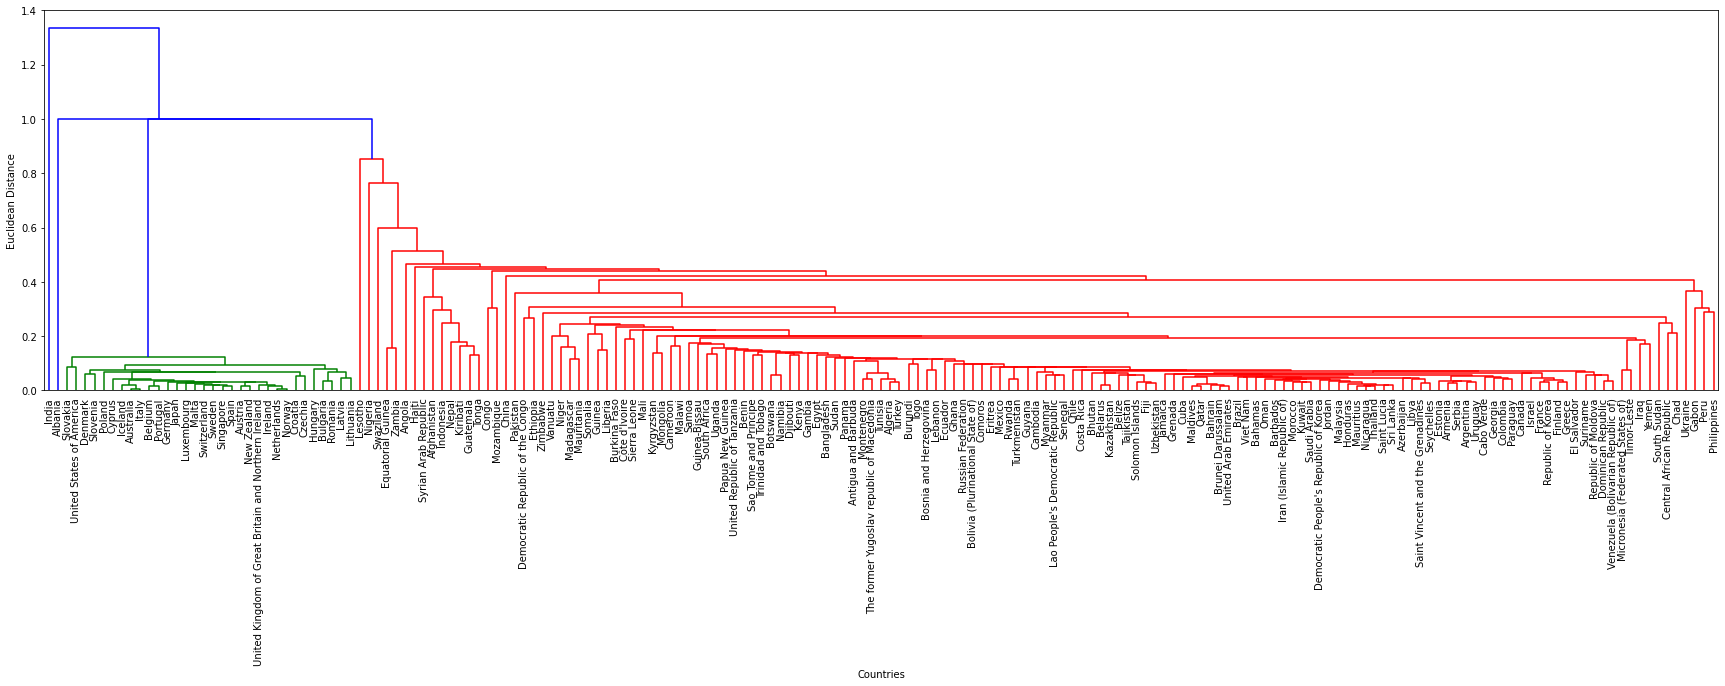

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generamos el clustering jerárquico
linked = linkage(dataset['X'], method='single')

# ploteamos el dendrograma
plt.figure(figsize=(30,7))
dendrogram(linked,
           orientation='top',
           labels=dataset['countries'],
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=10)
plt.xlabel('Countries')
plt.ylabel('Euclidean Distance')
plt.show()

Podemos observar que existen algunos grupos claramente distinguibles entre sí (los marcados con diferentes colores). También podemos ver que India y Albania son dos países con bastantes diferencias respecto al resto, y que cuesta mucho unir con el resto.

Si quisiéramos elegir una solución en particular, deberíamos trazar una línea horizontal en un valor de distancia euclídea e identificar el número de clusters resultantes. Por ejemplo, si la trazáramos en 0.8, tendríamos 5 clusters: uno para solamente la India, otro para Albania, otro para los países en verde, una para Lesotho y un último donde quedarían todos los países en rojo.

Para recuperar efectivamente esos mismos clusters, debemos aplicar el clustering aglomerativo una vez más. Hagámoslo ahora usando Sklearn, que incluye ```AgglomerativeClustering```. Con ```affinity``` determinamos la medida de distancia que queremos usar, mientras que con ```linkage``` determinamos el criterio de unión entre clusters. Usemos ```single``` para coincidir con la partición anterior. 

Si no queremos hacer dos pasos (```fit``` y ```predict```) podemos usar el método ```fit_predict``` para hacer las dos cosas a la vez.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# creamos el objeto para el clustering aglomerativo
agglomerative = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
# usamos fit predict para buscar los clusters y devolverlos
clusters_agglomerative = agglomerative.fit_predict(dataset['X'])

# imprimimos por pantalla los nombres de los países asignados a cada cluster
for k in np.unique(clusters_agglomerative):
  print('Cluster {}'.format(k))
  print(countries[clusters_agglomerative==k])
  print('======')

Cluster 0
['Afghanistan' 'Algeria' 'Angola' 'Antigua and Barbuda' 'Argentina'
 'Armenia' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Costa Rica' 'Cuba' "Côte d'Ivoire"
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Djibouti' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Ghana'
 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Indonesia' 'Iran (Islamic Republic of)' 'Iraq' 'Israel'
 'Jamaica' 'Jordan' 'Kazakhstan' 'Kenya' 'Kiribati' 'Kuwait' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Lebanon' 'Liberia' '

Podemos ver que efectivamente obtuvimos los clusters que habíamos visto al trazar la línea imaginaria vertical. Eventualmente podríamos buscar otras particiones y ver qué nos representan.

#### 3.4. "Evaluación" de las soluciones

Al no contar con etiquetas que me definan específicamente qué es una buena solución, no podemos compararnos con ningún ground truth y por ende no hay forma de determinar si la solución que obtuvimos (la partición en clusters) es la correcta. Sin embargo, existen algunas heurísticas que podemos aplicar para al menos estudiar qué tan bien distribuidos están esos clusters, y eventualmente decidir si me quedo con eso para un estudio más detallado de los resultados o si prefiero seguir trabajando en los parámetros de los algoritmos.

Vamos a evaluar los clusterings que construimos en función de las siguientes métricas:

* Índice de Davies Bouldin (cuanto más bajo, mejor)
* Coeficiente de silueta (cuanto más cerca de 1, mejor; cuando más cerca de -1, peor)

No usaremos el índice de Dunn porque no está implementado en Sklearn :(


K-means
DB score: 0.9829
Silhouette score: 0.4754
----------
Hierarchical Clustering
DB score: 0.3902
Silhouette score: 0.5241
----------


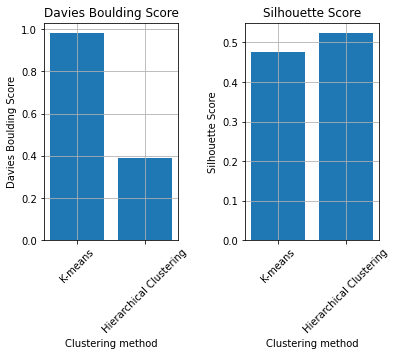

In [ ]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# inicializamos listas con los resultados de cada algoritmo y los nombres de los
# algoritmos
clusters_to_compare = [clusters_kmeans, clusters_agglomerative]
clustering_methods = ['K-means', 'Hierarchical Clustering']

# inicializamos vectores donde iremos guardando los resultados
db_scores = np.zeros(len(clusters_to_compare))
silhouette_scores = np.zeros(len(clusters_to_compare))

# por cada uno de los métodos
for i in range(len(clusters_to_compare)):
  # calculamos las métricas
  db_scores[i] = davies_bouldin_score(dataset['X'], clusters_to_compare[i])
  silhouette_scores[i] = silhouette_score(dataset['X'], clusters_to_compare[i])
  # las imprimimos
  print(clustering_methods[i])
  print('DB score: {:.4f}'.format(db_scores[i]))
  print('Silhouette score: {:.4f}'.format(silhouette_scores[i]))
  print('----------')

# inicializamos un gráfico para cada métrica
fig, axes = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
# graficamos el Davies Bouldin score
axes[0].bar(np.arange(db_scores.size), db_scores)
axes[0].set_title('Davies Boulding Score')
axes[0].set_xlabel('Clustering method')
axes[0].set_ylabel('Davies Boulding Score')
axes[0].set_xticks(np.arange(db_scores.size))
axes[0].set_xticklabels(clustering_methods, rotation=45)
axes[0].grid(True)
# y el Silhouette Score
axes[1].bar(np.arange(silhouette_scores.size), silhouette_scores)
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Clustering method')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(np.arange(silhouette_scores.size))
axes[1].set_xticklabels(clustering_methods, rotation=45)
axes[1].grid(True)

plt.show()

Vemos que en este caso logramos que el método de clustering jerárquico supere significativamente al de K-means en términos del Davies Boulding score. Esto implica que los clusters que encontramos con este método están mejor separados entre sí y son más densos internamente. Tengamos en cuenta que esa "densidad" puede deberse en parte a que tenemos algunos clusters con solamente 1 muestra. Esos clusters pueden demandar un análisis por separado: ¿qué pasa con India y Albania que se comportan tan diferente al resto de los países? Para responder esa pregunta deberíamos analizar las features individualmente, compararlas entre países, y hablar con sanitaristas y sociólogos para entender más acerca de esas diferencias.



### 4 Chau!

Con esto terminamos el curso 2 de Machine Learning de la DUIA! Espero que este material les haya sido útil, y que hayan podido aprender mucho a lo largo del curso.

Si tienen comentarios para hacer respecto a potenciales mejoras, son más que bienvenidos! Me pueden escribir a jiorlando@pladema.exa.unicen.edu.ar.

Nos vemos en unos meses en el módulo 6!